In [1]:
import os
os.chdir('./4-4/neural_style_transfer/')
import nst_utils
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from imageio import imread
from PIL import Image

In [2]:
tf.compat.v1.disable_eager_execution()

## what to do
- Build J_content(C, G)
- Build J_style(S, G)
- Build J(G) = alpha * J_content(C, G) + beta * J_style(S, G)

### 读取content图片

(300, 400, 3)


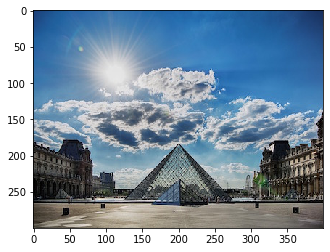

In [3]:
C = imread('./images/louvre_small.jpg')
print(C.shape)
plt.imshow(C)

### 计算内容代价J_content

In [4]:
def compute_J_content(a_C, a_G):

    '''
    input:
        a_C - (1, n_H, n_W, n_C), Tensor, activation of content image
        a_G - (1, n_H, n_W, n_C), Tensor, actication of generate image
    output:
        J_content = 1/(2*n_H*n_W*n_C) * ||a_C - a_G||**2
    '''

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    J_content = (1/(4*n_H*n_W*n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C, a_G)))
    return J_content

In [5]:
# 测试内容代价


tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as test:
    tf.compat.v1.set_random_seed(1)
    a_C = tf.compat.v1.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    a_G = tf.compat.v1.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    J_content = compute_J_content(a_C, a_G)
    J_content = test.run(J_content)
    print("J_content = " + str(J_content))

J_content = 6.7655926


### 读取风格图片

(300, 400, 3)


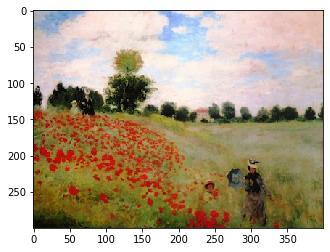

In [6]:
S = imread('./images/monet.jpg')
print(S.shape)
plt.imshow(S)

### 计算风格代价J_style

In [7]:
def compute_J_style(gram_S_list, gram_G_list, lambd_list=[0.2, 0.2, 0.2, 0.2, 0.2]):

    '''
    use layers[conv1_1, conv2_1, conv3_1, conv4_1, conv5_1]

    input:
        gram_S_list - (n_C, n_C), list of Tensor, gram matrix of style image in layers
        gram_G_list - (n_C, n_C), list of Tensor, gram matrix of generate image in layers
        lambd_lsit - weight of J in different layers
    output:
        J_style = sum(lambd * J_style_layer)
    '''

    J_style = 0.
    for i in range(5):
        gram_S = gram_S_list[i]
        gram_G = gram_G_list[i]
        n_C, n_C = gram_G.get_shape().as_list()
        lambd = lambd_list[i]
        J_style_layer = (1./(4 * n_C**2)) * tf.reduce_sum(tf.square(tf.subtract(gram_S, gram_G)))
        J_style += lambd * J_style_layer
        
    return J_style

In [8]:
def gram(a):
    
    '''
    input:
        a - activation of a layer, Tensor, (1, n_H, n_W, n_C)
    output:
        gram_matrix - (n_C, n_C)
    '''

    m, n_H, n_W, n_C = a.get_shape().as_list()
    a_2D = tf.reshape(a, [-1, n_C])
    a_2D_T = tf.transpose(a_2D)
    gram_matrix = tf.matmul(a_2D_T, a_2D) / (n_H * n_W)
    return gram_matrix

In [9]:
# 测试gram()


tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as test:
    tf.compat.v1.set_random_seed(1)
    a = tf.compat.v1.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    gram_a = gram(a)
    print("gram_a = " + str(test.run(gram_a)))

gram_a = [[14.726656   -5.2614555   3.1737256 ]
 [-5.2614555  21.642307    0.10505939]
 [ 3.1737256   0.10505939 13.939799  ]]


In [10]:
def gram_list(a_list):
    '''
    a_list - from layers[conv1_1, conv2_1, conv3_1, conv4_1, conv5_1]
    '''
    gram_matrix_list = [gram(a) for a in a_list]
    return gram_matrix_list

In [11]:
# 测试gram_list()


tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as test:
    tf.compat.v1.set_random_seed(1)
    a = tf.compat.v1.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    b = tf.compat.v1.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    gram_list_ab = gram_list([a, b])
    print("gram_list_ab = " + str(test.run(gram_list_ab)))

gram_list_ab = [array([[14.726656  , -5.2614555 ,  3.1737256 ],
       [-5.2614555 , 21.642307  ,  0.10505939],
       [ 3.1737256 ,  0.10505939, 13.939799  ]], dtype=float32), array([[12.218045  ,  0.48486936, -0.2807442 ],
       [ 0.48486936,  7.655669  ,  4.4871783 ],
       [-0.2807442 ,  4.4871783 , 14.725692  ]], dtype=float32)]


In [12]:
# 测试风格代价J_style


tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as test:
    tf.compat.v1.set_random_seed(1)
    a_C = tf.compat.v1.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    a_G = tf.compat.v1.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    c = tf.compat.v1.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    d = tf.compat.v1.random_normal([1, 5, 5, 3], mean = 1, stddev = 4)
    e = tf.compat.v1.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    f = tf.compat.v1.random_normal([1, 5, 5, 3], mean = 1, stddev = 4)
    g = tf.compat.v1.random_normal([1, 6, 6, 3], mean = 1, stddev = 4)
    i = tf.compat.v1.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    j = tf.compat.v1.random_normal([1, 5, 5, 3], mean = 1, stddev = 4)
    k = tf.compat.v1.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    l = tf.compat.v1.random_normal([1, 5, 5, 3], mean = 1, stddev = 4)
    m = tf.compat.v1.random_normal([1, 6, 6, 3], mean = 1, stddev = 4)
    a_S_list = [c, d, e, f, g]
    a_G_list = [i, j, k, l, m]
    J_style = compute_J_style(gram_list(a_S_list), gram_list(a_G_list), lambd_list=[0.2, 0.2, 0.2, 0.2, 0.2])
    J_style = test.run(J_style)
    print("J_style = " + str(J_style))

J_style = 6.748059


### 计算总代价J

In [13]:
def compute_J(a_C, a_G, a_S_list, a_G_list, alpha=10, beta=40):
    J_content = compute_J_content(a_C, a_G)
    J_style = compute_J_style(gram_list(a_S_list), gram_list(a_G_list), lambd_list=[0.2, 0.2, 0.2, 0.2, 0.2])
    J = alpha * J_content + beta * J_style
    return J

In [14]:
# 测试代价函数J


tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as test:
    tf.compat.v1.set_random_seed(1)
    a_C = tf.compat.v1.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    a_G = tf.compat.v1.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    c = tf.compat.v1.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    d = tf.compat.v1.random_normal([1, 5, 5, 3], mean = 1, stddev = 4)
    e = tf.compat.v1.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    f = tf.compat.v1.random_normal([1, 5, 5, 3], mean = 1, stddev = 4)
    g = tf.compat.v1.random_normal([1, 6, 6, 3], mean = 1, stddev = 4)
    i = tf.compat.v1.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    j = tf.compat.v1.random_normal([1, 5, 5, 3], mean = 1, stddev = 4)
    k = tf.compat.v1.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    l = tf.compat.v1.random_normal([1, 5, 5, 3], mean = 1, stddev = 4)
    m = tf.compat.v1.random_normal([1, 6, 6, 3], mean = 1, stddev = 4)
    a_S_list = [c, d, e, f, g]
    a_G_list = [i, j, k, l, m]
    J = compute_J(a_C, a_G, a_S_list, a_G_list)
    print("J = " + str(test.run(J)))

J_valid = 10*J_content + 40*J_style
print('J_valid = ' + str(J_valid))

J = 337.5783
J_valid = 337.5782775878906


### 加载vgg模型

In [15]:
tf.compat.v1.reset_default_graph()
model = nst_utils.load_vgg_model('pretrained-model/imagenet-vgg-verydeep-19.mat')
print(type(model))
for key,value in model.items():
    print(key, '\t', value, end='\n\n')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
<class 'dict'>
input 	 <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32>

conv1_1 	 Tensor("Relu:0", shape=(1, 300, 400, 64), dtype=float32)

conv1_2 	 Tensor("Relu_1:0", shape=(1, 300, 400, 64), dtype=float32)

avgpool1 	 Tensor("AvgPool:0", shape=(1, 150, 200, 64), dtype=float32)

conv2_1 	 Tensor("Relu_2:0", shape=(1, 150, 200, 128), dtype=float32)

conv2_2 	 Tensor("Relu_3:0", shape=(1, 150, 200, 128), dtype=float32)

avgpool2 	 Tensor("AvgPool_1:0", shape=(1, 75, 100, 128), dtype=float32)

conv3_1 	 Tensor("Relu_4:0", shape=(1, 75, 100, 256), dtype=float32)

conv3_2 	 Tensor("Relu_5:0", shape=(1, 75, 100, 256), dtype=float32)

conv3_3 	 Tensor("Relu_6:0", shape=(1, 75, 100, 256), dtype=float32)

conv3_4 	 Tensor("Relu_7:0", shape=(1, 75, 100, 256), dtype=float32)

avgpool3 	 Tensor("AvgPool_2:0", shape=(1, 38, 50, 256), dtype=float32)

conv4_1 	 Tensor("Relu_8:0", shape=(1, 38, 50, 512),

### 计算a_C

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


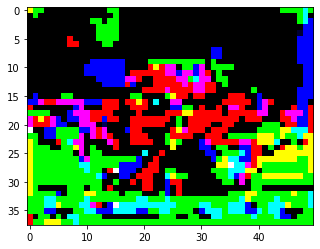

In [16]:
Content = nst_utils.reshape_and_normalize_image(C)
with tf.compat.v1.Session() as sess:
    sess.run(model['input'].assign(Content))
    a_C = sess.run(model["conv4_2"])
    plt.imshow(a_C[0][...,:3])

In [17]:
a_C

array([[[[ 42.512897,  94.233864,   0.      , ..., 918.76855 ,
          110.00524 ,   0.      ],
         [  0.      , 247.39963 ,   0.      , ..., 926.1366  ,
            0.      ,   0.      ],
         [  0.      , 152.55891 ,   0.      , ..., 584.11444 ,
            0.      ,   0.      ],
         ...,
         [  0.      , 275.81863 ,   0.      , ..., 854.5024  ,
            0.      ,   0.      ],
         [  0.      , 347.58975 ,  25.243345, ..., 895.9469  ,
            0.      ,   0.      ],
         [  0.      , 195.68047 ,   0.      , ..., 838.5026  ,
           82.754944,   0.      ]],

        [[  0.      ,   0.      ,   0.      , ..., 389.33072 ,
          340.95612 ,   0.      ],
         [  0.      ,  12.025807,   0.      , ..., 249.40363 ,
            0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      , ...,   0.      ,
            0.      ,   0.      ],
         ...,
         [  0.      ,  97.84668 ,   0.      , ...,   0.      ,
            0.      ,   0

### 计算a_S_list

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
<class 'numpy.ndarray'> (1, 300, 400, 64)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


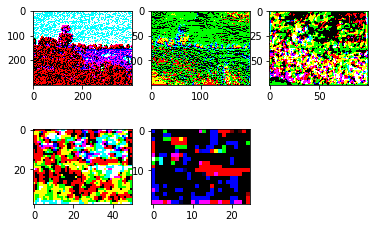

In [18]:
Style = nst_utils.reshape_and_normalize_image(S)
with tf.compat.v1.Session() as sess:
    sess.run(model['input'].assign(Style))
    a_S_list = sess.run([model["conv1_1"], model["conv2_1"], model["conv3_1"], model["conv4_1"], model['conv5_1']])
    print(type(a_S_list[0]),a_S_list[0].shape)
    plt.subplot(2,3,1)
    plt.imshow(a_S_list[0][0][...,:3])
    plt.subplot(2,3,2)
    plt.imshow(a_S_list[1][0][...,:3])
    plt.subplot(2,3,3)
    plt.imshow(a_S_list[2][0][...,:3])
    plt.subplot(2,3,4)
    plt.imshow(a_S_list[3][0][...,:3])
    plt.subplot(2,3,5)
    plt.imshow(a_S_list[4][0][...,:3])

In [19]:
a_S_list


 
         [[  0.       ,  31.271338 ,   2.482535 , ...,   0.       ,
             0.       ,   0.       ],
          [  0.       ,  51.021225 ,  31.568865 , ...,   0.       ,
             0.       ,   0.       ],
          [  0.       ,  53.116203 ,  33.916077 , ...,   0.       ,
             0.       ,   1.3788824],
          ...,
          [  0.       ,  14.845742 ,  31.339933 , ...,   0.       ,
             9.065327 ,  36.876648 ],
          [  0.       ,  13.923921 ,  30.985964 , ...,   0.       ,
             6.502288 ,  35.762115 ],
          [198.37625  ,  37.006783 ,  88.935585 , ...,   0.       ,
           185.60977  , 237.12703  ]],
 
         ...,
 
         [[177.43425  ,   0.       ,   3.6430082, ..., 178.81078  ,
           141.88893  , 122.85885  ],
          [  2.0699756,   0.       ,   0.       , ..., 273.1276   ,
             4.485656 ,   0.       ],
          [  4.299845 ,   0.       ,   0.       , ..., 271.89954  ,
             0.       ,   0.       ],
         

## Build compute graph

In [20]:
input_image = nst_utils.generate_noise_image(Content, noise_ratio=nst_utils.CONFIG.NOISE_RATIO)
a_C = tf.constant(a_C)
a_S_list = [tf.constant(x) for x in a_S_list]
a_G = model["conv4_2"]
a_G_list = [model["conv1_1"], model["conv2_1"], model["conv3_1"], model["conv4_1"], model['conv5_1']]
J = compute_J(a_C, a_G, a_S_list, a_G_list, alpha=10, beta=40)
train_op = tf.train.AdamOptimizer(2.).minimize(J)

AttributeError: module 'tensorflow_core._api.v2.train' has no attribute 'AdamOptimizer'

## Train

In [0]:
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())
sess.run(model['input'].assign(input_image))

In [0]:
for epoch in range(5):
    _, loss = sess.run([train_op, J])
    print(epoch, loss)
    image_gen = sess.run(model['input'])
    if epoch % 1 == 0:
        nst_utils.save_image(f'./output/{epoch}.png', image_gen)

In [0]:
# image_gen = image_gen + nst_utils.CONFIG.MEANS
# output_image = np.clip(image_gen[0], 0, 255).astype('uint8')
# plt.imshow(output_image)

In [0]:
# sess.close()